In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from itertools import product
from IPython.display import display


import pandas as pd
import altair as alt

alt.renderers.enable('notebook')
alt.data_transformers.enable('json') #enables graphs with more than 5k lines. It stores info in a local file

DataTransformerRegistry.enable('json')

In [365]:
class Simulation:
    def __init__(self, genome_length, n_females, n_males, sub_rate, offsprings_per_female=1, fitness_weight=1.0, seed=None):
        self.genome_length = genome_length
        self.n_females = n_females
        self.n_males = n_males
        self.sub_rate = sub_rate
        self.offsprings_per_female = offsprings_per_female
        self.fitness_weight = fitness_weight
        self.n_female_sub = int(sub_rate * n_females)
        self.n_male_sub = int(sub_rate * n_males)
        self.powers = np.array([2**i for i in range(genome_length)])
        if seed == None:
            seed = int(time.time())
        self.seed = seed
        np.random.seed(seed)
        
        
    def set_populations(self):
        self.females = np.random.randint(0, 2, (self.n_females, self.genome_length))
        self.males = np.random.randint(0, 2, (self.n_males, self.genome_length))
        
        
    def calculate_fitness_matrix(self):
        return - (self.females.reshape(self.n_females,1,self.genome_length) == self.males).sum(axis=2) * \
                self.fitness_weight + np.abs(self.genome_length - 2 * self.males.sum(1) )

    
    def select_partners(self):
        """
        Selects the indexes of the right male partner for every female. Equally good partners are
        randomly selected
        """
        partners = np.zeros(self.n_females,dtype=np.int)
        fitness = self.calculate_fitness_matrix()
        maxes = np.max(fitness,axis=1)
        for i in range(self.n_females):
            partners[i] = np.random.choice(np.where(fitness[i,:] == maxes[i])[0],1)
        return partners
       
        
    def generate_sons(self):
        return np.where(np.random.randint(0,2,(self.n_females * self.offsprings_per_female, self.genome_length)),
                        self.females[list(range(self.n_females)) * self.offsprings_per_female],
                        self.males[list(self.select_partners()) * self.offsprings_per_female])
    
    
    def evolve(self, time, stats_dt):
        stats = pd.DataFrame(columns=['sex','genome','timestep','partner','n_copulations'],
                             index=np.arange(time / stats_dt * (self.n_males + self.n_females),dtype=np.int))
        progress = 0
        for i in range(time):
            
            #calculating the statistics:
            if(i % stats_dt == 0):
                partners  = self.select_partners()
                for ind in range(self.n_males):
                    stats.loc[progress] = ['M', self.males[ind].dot(self.powers), i, np.nan,(partners==ind).sum()]
                    progress += 1
                for ind in range(self.n_females):
                    stats.loc[progress] = ['F', self.females[ind].dot(self.powers), i, self.males[partners[ind]].dot(self.powers),np.nan]
                    progress += 1
                
            #mixing the offsprings in the population NO NATURAL SELECTION IS TAKEN INTO ACCOUT 
            sons = self.generate_sons()[np.random.choice(self.n_females * self.offsprings_per_female,
                                                        self.n_female_sub + self.n_male_sub,
                                                        replace=False),:]
            self.females[np.random.choice(self.n_females,self.n_female_sub,replace=False),:] = sons[:self.n_female_sub]
            self.males[np.random.choice(self.n_males, self.n_male_sub, replace=False),:] = sons[-self.n_male_sub:]
       
        #setting the right types for the stats Dataframe
        stats.to_csv('test.csv')
    
    
    def count_different_genomes(self,objs):
        """
        args:
        objs - list of genomes

        returns:

        number of different genomes inside the given list. 

        obj are converted to strings because the  not in operation for np.arrays is more complex and ambiguous written in this way"""
        differents = []
        for obj in objs:
            st = str(obj)
            if st not in differents:
                differents.append(st)
        return len(differents)
    
    
    def sons_statistics(self):
#         Distribution of sons for the current male and female population.
        sons_count = np.zeros(2 ** self.genome_length)
        sons = np.zeros((2 ** self.genome_length, self.genome_length))
        partners = self.select_partners()
        for ind in range(self.n_females):
            for son in product(*np.array([self.males[partners[ind]],self.females[ind]]).transpose()):
                sons_count[np.array(son).dot(self.powers)] += 1
        return sons_count
        
        
        

In [380]:
# Initialization of the simulation. 
k = Simulation(genome_length=3,
               n_females=40,
               n_males=40,
               sub_rate=0.3,
               offsprings_per_female=1,
               fitness_weight=1,
               seed = 1558367451
               )
print(f"current seed:{k.seed}")
k.set_populations()

current seed:1558367451


In [383]:
# Evolution of the system. Stats are recorded every STAT_STEP steps and are saved in test.csv
SIM_LENGTH = 300
STAT_STEP = 1
k.evolve(SIM_LENGTH, STAT_STEP)

#preparation of the dataframe needed for visualization
stats = pd.read_csv('test.csv')
st = stats[['timestep','sex','genome']]
r2 = st.groupby(['timestep','sex']).agg(lambda x: sum([((x==j).sum()**2) for j in x.unique()])).reset_index()

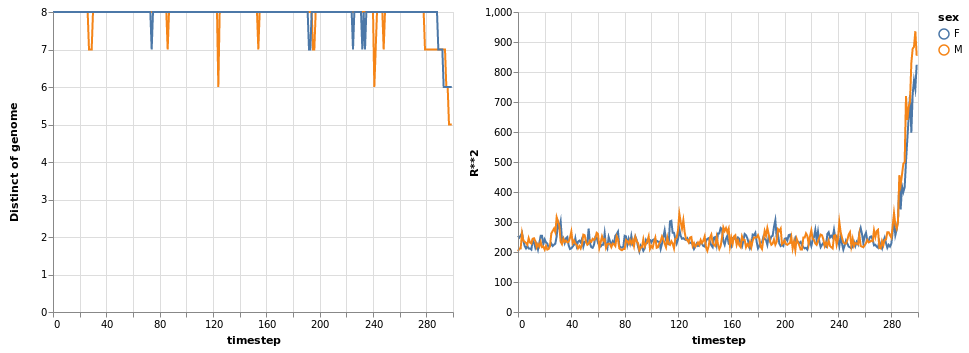

In [384]:
#visualization of variety inside the genome pool and measure of distance from uniform distribution
c1 = alt.Chart(stats[['timestep','sex','genome']]).mark_line().encode(
    x = 'timestep',
    y = 'distinct(genome)',
    color = 'sex')
c2 = alt.Chart(r2).mark_line().encode(
    x = 'timestep',
    y = alt.Y('genome',title='R**2'),
    color = 'sex')

c1 |c2

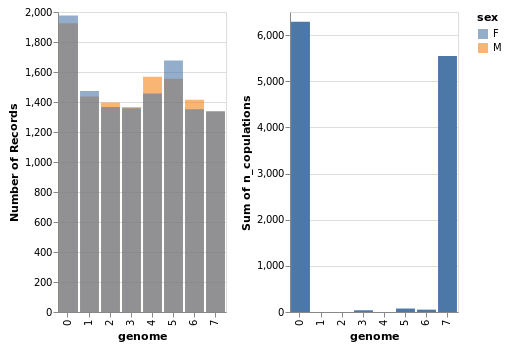

In [385]:
#visualization of populations for both sexes and reproductive success of males based on their genome

copulations = stats.drop(['partner','Unnamed: 0'],axis=1)[stats['sex'] =="M"]
slider = alt.binding_range(min=0, max=SIM_LENGTH, step=STAT_STEP)
select_timestep = alt.selection_single(name="timestep", fields=['timestep'],
                                       bind=slider)

c_pops = alt.Chart(stats).mark_bar(opacity=0.6).encode(
    x = 'genome:N',
    y = alt.Y('count()', stack=None),
    color = alt.Color('sex'),
    tooltip = 'count()'
).add_selection(
    select_timestep
).transform_filter(
    select_timestep
)

c_copulations = alt.Chart(copulations).mark_bar().encode(
    x = 'genome:N',
    y = 'sum(n_copulations)'
).add_selection(
    select_timestep
).transform_filter(
    select_timestep
)

c_pops | c_copulations

In [262]:
#Code needed to explore sons distribution at fixed female and male populations.


# # k.males = np.array( [list(np.binary_repr(n,3)) for n in range(2**3)],dtype=int)
# k.females = np.array(([0,0,0],[0,0,0]))
# plt.plot(range(8),k.sons_statistics(),label='sons genetic distribution')
# plt.hist([k.males[i].dot(k.powers) for i in k.select_partners()], bins=np.arange(-0.5,8.5,1),label='partners')
# plt.legend()